Training device: CPU
Epoch 10, Loss: 0.0197, Val Loss: 0.0325
Epoch 20, Loss: 0.0159, Val Loss: 0.0324
Epoch 30, Loss: 0.0218, Val Loss: 0.0424
Epoch 40, Loss: 0.0154, Val Loss: 0.0281
Epoch 50, Loss: 0.0180, Val Loss: 0.0331
Epoch 60, Loss: 0.0144, Val Loss: 0.0297
Epoch 70, Loss: 0.0124, Val Loss: 0.0325
Epoch 80, Loss: 0.0148, Val Loss: 0.0279
Epoch 90, Loss: 0.0128, Val Loss: 0.0277
Epoch 100, Loss: 0.0127, Val Loss: 0.0268
Epoch 110, Loss: 0.0146, Val Loss: 0.0337
Epoch 120, Loss: 0.0141, Val Loss: 0.0276
Epoch 130, Loss: 0.0115, Val Loss: 0.0266
Epoch 140, Loss: 0.0115, Val Loss: 0.0320
Epoch 150, Loss: 0.0132, Val Loss: 0.0363
Epoch 160, Loss: 0.0129, Val Loss: 0.0330
Epoch 170, Loss: 0.0113, Val Loss: 0.0253
Epoch 180, Loss: 0.0111, Val Loss: 0.0285
Epoch 190, Loss: 0.0121, Val Loss: 0.0262
Epoch 200, Loss: 0.0104, Val Loss: 0.0359


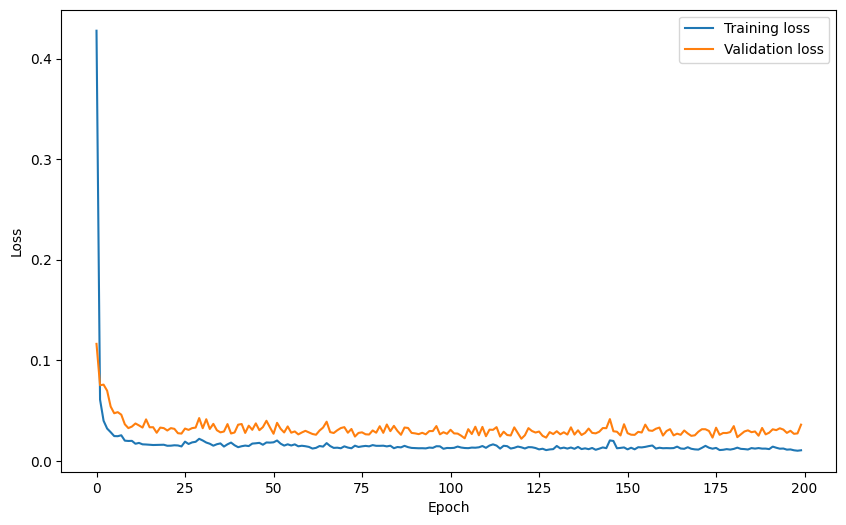

4/4 [==============================] - 0s 1ms/step


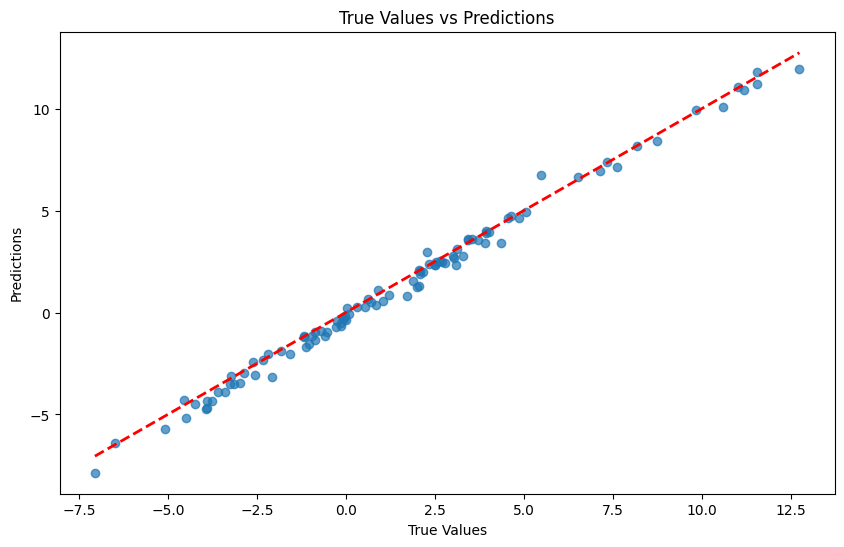

1/1 [==============================] - 0s 22ms/step
Predicted y for X = [ 1.  -0.5  0.8  1.2]: -0.80
True y for X = [ 1.  -0.5  0.8  1.2]: -0.10


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Force TensorFlow to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

# Generate synthetic data with 4 features
np.random.seed(0)
num_samples = 1000
X = np.random.randn(num_samples, 4).astype(np.float32)
y = (2 * X[:, 0]**2 + 3 * X[:, 1] - 1.5 * X[:, 2] + 0.5 * X[:, 3] + 
     np.random.normal(0, 0.5, size=num_samples)).astype(np.float32)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
X_mean, X_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
y_mean, y_std = np.mean(y_train), np.std(y_train)

X_train_norm = (X_train - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std
y_train_norm = (y_train - y_mean) / y_std
y_val_norm = (y_val - y_mean) / y_std

# Define the model
class FunctionApproximator(keras.Model):
    def __init__(self):
        super(FunctionApproximator, self).__init__()
        self.dense1 = keras.layers.Dense(32, activation='relu', input_shape=(4,))
        self.dense2 = keras.layers.Dense(32, activation='relu')
        self.dense3 = keras.layers.Dense(1)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

# Instantiate the model, loss function, and optimizer
model = FunctionApproximator()
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Custom training loop
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(x, y):
    predictions = model(x)
    loss = loss_fn(y, predictions)
    return loss

# Training
epochs = 200
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train_norm.reshape(-1, 1))).shuffle(1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val_norm.reshape(-1, 1))).batch(batch_size)

train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_train_losses = []
    epoch_val_losses = []
    
    for x_batch, y_batch in train_dataset:
        train_loss = train_step(x_batch, y_batch)
        epoch_train_losses.append(train_loss)
    
    for x_val_batch, y_val_batch in val_dataset:
        val_loss = val_step(x_val_batch, y_val_batch)
        epoch_val_losses.append(val_loss)
    
    train_losses.append(tf.reduce_mean(epoch_train_losses))
    val_losses.append(tf.reduce_mean(epoch_val_losses))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_losses[-1].numpy():.4f}, Val Loss: {val_losses[-1].numpy():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
X_test = np.random.randn(100, 4).astype(np.float32)
X_test_norm = (X_test - X_mean) / X_std
y_pred_norm = model.predict(X_test_norm)
y_pred = y_pred_norm * y_std + y_mean

y_true = (2 * X_test[:, 0]**2 + 3 * X_test[:, 1] - 1.5 * X_test[:, 2] + 0.5 * X_test[:, 3]).astype(np.float32)

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

# Make a prediction
new_X = np.array([[1.0, -0.5, 0.8, 1.2]])
new_X_norm = (new_X - X_mean) / X_std
predicted_y_norm = model.predict(new_X_norm)
predicted_y = predicted_y_norm * y_std + y_mean

print(f"Predicted y for X = {new_X[0]}: {predicted_y[0][0]:.2f}")
true_y = 2 * new_X[0, 0]**2 + 3 * new_X[0, 1] - 1.5 * new_X[0, 2] + 0.5 * new_X[0, 3]
print(f"True y for X = {new_X[0]}: {true_y:.2f}")